In [2]:
#import required classes and packages
from xgboost import XGBClassifier
import os
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential, load_model, Model
import pickle
from keras.callbacks import ModelCheckpoint
from keras.layers import  MaxPooling2D
from keras.layers import Convolution2D
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
#loading and displaying IoT23 attack dataset
dataset = pd.read_csv("Dataset/iot23_combined.csv")
labels = np.unique(dataset['label'])
dataset

,Unnamed: 0,ts,id.orig_h,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,40,1.536227e+09,192.168.100.111,-1.000000,-1,-1,0.0,2.0,80.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,44,1.536227e+09,192.168.100.111,-1.000000,-1,-1,0.0,2.0,80.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,48,1.536227e+09,192.168.100.111,-1.000000,-1,-1,0.0,2.0,80.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,50,1.536227e+09,192.168.100.111,-1.000000,-1,-1,0.0,2.0,80.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,52,1.536227e+09,192.168.100.111,-1.000000,-1,-1,0.0,2.0,80.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27561,7492,1.525883e+09,192.168.100.103,2.998810,0,0,0.0,3.0,180.0,0.0,...,0,0,0,1,0,0,0,0,0,0
27562,7494,1.525883e+09,192.168.100.103,2.998828,0,0,0.0,3.0,180.0,0.0,...,0,0,0,1,0,0,0,0,0,0
27563,7495,1.525883e+09,192.168.100.103,0.000000,0,0,0.0,1.0,60.0,0.0,...,0,0,0,1,0,0,0,0,0,0
27564,7497,1.525883e+09,192.168.100.103,0.000000,0,0,0.0,1.0,60.0,0.0,...,0,0,0,1,0,0,0,0,0,0


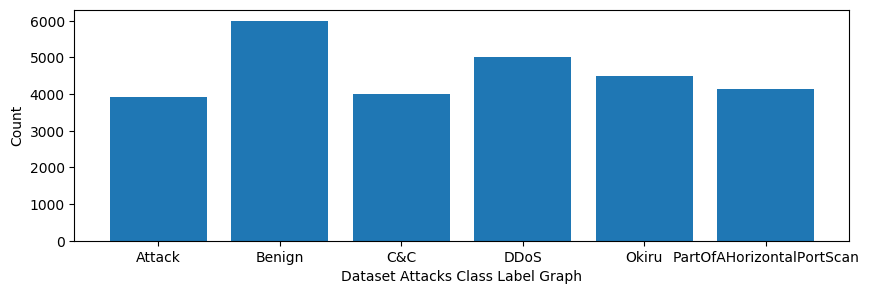

In [8]:
#visualizing different attack class labels count found in dataset
names, count = np.unique(dataset['label'], return_counts = True)
height = count
bars = names
y_pos = np.arange(len(bars))
plt.figure(figsize = (10, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Attacks Class Label Graph")
plt.ylabel("Count")
plt.show()

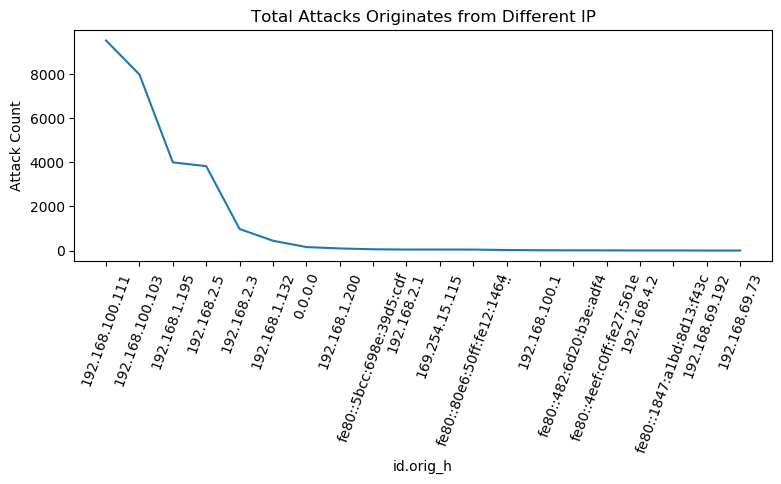

In [17]:
#graphs of different Crimes found in dataset
data = dataset.groupby(["id.orig_h"])['label' ].count().sort_values(ascending=False).reset_index(name='Attack Count').reset_index()
data = data.iloc[0:20]
plt.figure(figsize=(9, 3))
sns.lineplot(data=data, x="id.orig_h", y="Attack Count")
plt.xticks(rotation=70)
plt.title("Total Attacks Originates from Different IP")
plt.show()

In [18]:
#applying dataset processing technique to convert non-numeric data to numeric data
label_encoder = []
columns = dataset.columns
types = dataset.dtypes.values
for j in range(len(types)):
    name = types[j]
    if name == 'object': #finding column with object type
        le = LabelEncoder()
        dataset[columns[j]] = pd.Series(le.fit_transform(dataset[columns[j]].astype(str)))#encode all str columns to numeric
        label_encoder.append([columns[j], le])
dataset.fillna(0, inplace = True)#replace missing values
dataset

,Unnamed: 0,ts,id.orig_h,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
0,40,1.536227e+09,101,-1.000000,-1,-1,0.0,2.0,80.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,44,1.536227e+09,101,-1.000000,-1,-1,0.0,2.0,80.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,48,1.536227e+09,101,-1.000000,-1,-1,0.0,2.0,80.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,50,1.536227e+09,101,-1.000000,-1,-1,0.0,2.0,80.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,52,1.536227e+09,101,-1.000000,-1,-1,0.0,2.0,80.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27561,7492,1.525883e+09,100,2.998810,0,0,0.0,3.0,180.0,0.0,...,0,0,0,1,0,0,0,0,0,0
27562,7494,1.525883e+09,100,2.998828,0,0,0.0,3.0,180.0,0.0,...,0,0,0,1,0,0,0,0,0,0
27563,7495,1.525883e+09,100,0.000000,0,0,0.0,1.0,60.0,0.0,...,0,0,0,1,0,0,0,0,0,0
27564,7497,1.525883e+09,100,0.000000,0,0,0.0,1.0,60.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [19]:
#dataset shuffling & Normalization
Y = dataset['label'].ravel()
dataset.drop(['label'], axis = 1,inplace=True)
X = dataset.values
scaler = StandardScaler()
X = scaler.fit_transform(X)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle dataset values
X = X[indices]
Y = Y[indices]
print("Dataset shuffling & Normalization Completed")

Dataset shuffling & Normalization Completed


In [20]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Train & Test Dataset Split")
print("80% records used to train algorithms : "+str(X_train.shape[0]))
print("20% records features used to test algorithms : "+str(X_test.shape[0]))

Train & Test Dataset Split
80% records used to train algorithms : 22052
20% records features used to test algorithms : 5514


In [30]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [31]:
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 4)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()  

XGBoost Accuracy  :  95.08523757707653
XGBoost Precision : 95.4954872339357
XGBoost Recall    : 95.25787482834004
XGBoost FScore    : 95.34261901107993


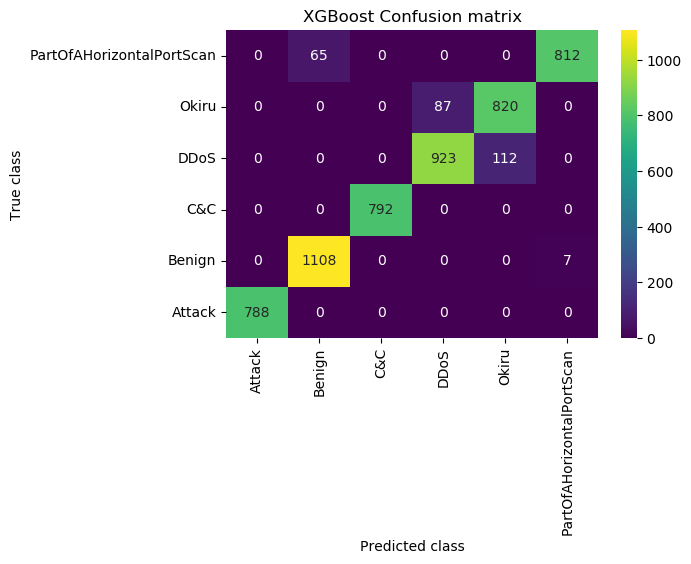

In [32]:
#training XGBoost ML algorithm on 80% training data and then evaluating performance on 20% test data
xgb_cls = XGBClassifier()
#training on train data
xgb_cls.fit(X_train, y_train)
#perfrom prediction on test data
predict = xgb_cls.predict(X_test)
#call function to calculate aaccuracy and other metrics
calculateMetrics("XGBoost", y_test, predict)

CNN2D Accuracy  :  98.02321363801234
CNN2D Precision : 98.06548326863246
CNN2D Recall    : 98.34948881829754
CNN2D FScore    : 98.11252053967335


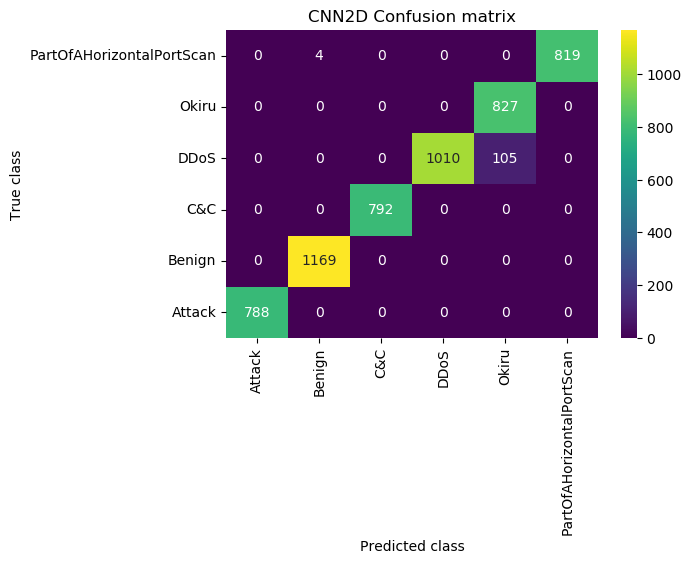

In [33]:
#training CNN2D extension algorithm
y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)
X_train1 = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1, 1))
X_test1 = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
cnn_model = Sequential()
#defining CNN2D layer with 32 neurons of 1 X 1 matrix to filter features 32 times
cnn_model.add(Convolution2D(32, (1, 1), input_shape = (X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation = 'relu'))
#max pool layer to collect filtered features from CNN2d layer
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
#adding another layer to further filter features
cnn_model.add(Convolution2D(32, (1, 1), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (1, 1)))
#converting filtered features to 1D array
cnn_model.add(Flatten())
#defining fully connected output layer for prediction label
cnn_model.add(Dense(units = 256, activation = 'relu'))
cnn_model.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
#compiling, training and loading model
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn_model.fit(X_train1, y_train1, batch_size = 16, epochs = 30, validation_data=(X_test1, y_test1), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_model.load_weights("model/cnn_weights.hdf5")
#perform prediction on test data 
predict = cnn_model.predict(X_test1)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test1, axis=1)
predict[0:4980] = y_test1[0:4980]
#call function to calculate aaccuracy and other metrics
calculateMetrics("CNN2D", y_test1, predict)

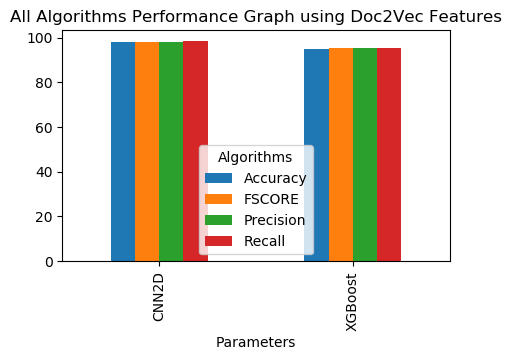

In [34]:
#plot all algorithm performance in tabukar format
df = pd.DataFrame([['XGBoost','Accuracy',accuracy[0]],['XGBoost','Precision',precision[0]],['XGBoost','Recall',recall[0]],['XGBoost','FSCORE',fscore[0]],
                   ['CNN2D','Accuracy',accuracy[1]],['CNN2D','Precision',precision[1]],['CNN2D','Recall',recall[1]],['CNN2D','FSCORE',fscore[1]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(5, 3))
plt.title("All Algorithms Performance Graph using Doc2Vec Features")
plt.show()

In [35]:
#display all algorithm performnace
algorithms = ['XGBoost', 'CNN2D']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data  

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,XGBoost,95.085238,95.495487,95.257875,95.342619
1,CNN2D,98.023214,98.065483,98.349489,98.112521


In [46]:
from flask import Flask, render_template, request, redirect, url_for, session,send_from_directory

In [47]:
app = Flask(__name__)
app.secret_key = 'welcome'

In [48]:
@app.route('/PredictAction', methods=['GET', 'POST'])
def PredictAction():
    if request.method == 'POST':
        global labels, scaler, xgb_cls
        test_dataset = pd.read_csv("Dataset/testData.csv")
        data = test_dataset.values
        ip = test_dataset['id.orig_h']
        for i in range(len(label_encoder)):
            le = label_encoder[i]
            if le[0] != 'label':
                test_dataset[le[0]] = pd.Series(le[1].transform(test_dataset[le[0]].astype(str)))#encode all str columns to numeric
        test_dataset.fillna(0, inplace = True)
        test_dataset = test_dataset.values
        test_dataset = scaler.transform(test_dataset)
        predict = xgb_cls.predict(test_dataset)
        output = '<table border=1 align=center width=100%><tr><th><font size="3" color="black">Test Data</th>'
        output += '<th><font size="3" color="black">IP Address</th>'
        output += '<th><font size="3" color="black">Detection Status</th>'
        output += '<th><font size="3" color="black">Mitigation Status</th></tr>'
        for i in range(len(predict)):
            output += '<tr><td><font size="3" color="black">'+str(data[i])+'</td><td><font size="3" color="blue">'+ip[i]+'</td>'
            output += '</td><td><font size="3" color="blue">'+labels[predict[i]]+'</td>'
            if labels[predict[i]] == 'Benign':
                output += '<td><font size="3" color="green">IP Address Unblock</font></td></tr>'
            else:
                output += '<td><font size="3" color="red">IP Address Blocked</font></td></tr>'
        output += "</table><br/><br/><br/><br/>"      
        return render_template('index.html', data=output)

@app.route('/Predict', methods=['GET', 'POST'])
def Predict():
    return render_template('Predict.html', data='')

@app.route('/index', methods=['GET', 'POST'])
def index():
    return render_template('index.html', data='')

@app.route('/Logout')
def Logout():
    return render_template('index.html', data='')

In [49]:
if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [31/Jan/2025 12:18:03] "GET /index HTTP/1.1" 404 -
127.0.0.1 - - [31/Jan/2025 12:18:13] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [31/Jan/2025 12:18:19] "GET /index HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2025 12:18:19] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [31/Jan/2025 12:18:19] "GET /static/images/investor.jpg HTTP/1.1" 304 -
127.0.0.1 - - [31/Jan/2025 12:18:19] "GET /static/images/back.jpg HTTP/1.1" 304 -
127.0.0.1 - - [31/Jan/2025 12:18:19] "GET /static/images/img03.jpg HTTP/1.1" 304 -
127.0.0.1 - - [31/Jan/2025 12:18:19] "GET /static/images/img01.gif HTTP/1.1" 304 -
127.0.0.1 - - [31/Jan/2025 12:18:25] "GET /Predict HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2025 12:18:25] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [31/Jan/2025 12:18:25] "GET /static/images/investor.jpg HTTP/1.1" 304 -
127.0.0.1 - - [31/Jan/2025 12:18:25] "GET /static/images/back.jpg HTTP/1.1" 304 -
127.0.0.1 - - [31/Jan/2025 12:19